In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
Chengdu = pd.read_csv("/Users/kayinho/Downloads/FiveCitiePMData/ChengduPM20100101_20151231.csv")


In [3]:
Chengdu.drop(['PM_Caotangsi', 'PM_Shahepu','season', 'precipitation', 'Iprec', 'cbwd'], 
               axis=1,
              inplace=True)


In [4]:
Chengdu.dropna(axis=0, how="any", inplace=True)
Chengdu['Time'] = pd.to_datetime(Chengdu['year'].map(str) +"/"+ Chengdu['month'].map(str) +"/"+ Chengdu['day'].map(str)+" "+Chengdu['hour'].map(str)+":00:00")


In [5]:
Chengdu_1 = Chengdu.groupby(['Time']).mean()


In [6]:
Chengdu_1.index = pd.to_datetime(Chengdu_1.index, 
                             format='%d-%m-%Y %H:%M:%S')
Chengdu_1 = Chengdu_1.set_index(Chengdu_1.index).asfreq('H')
Chengdu_1 = Chengdu_1.fillna(method='ffill')
Chengdu_1['Time'] = Chengdu_1.index


In [7]:
Chengdu_13 = Chengdu_1[(Chengdu_1['Time'] >=pd.to_datetime('20130501030000')) & (Chengdu_1['Time'] <= pd.to_datetime('20150430030000'))]
Chengdu_13 = Chengdu_13.set_index(Chengdu_13.index).asfreq('D')



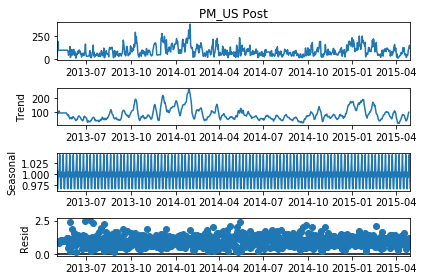

In [8]:
split_result = seasonal_decompose(Chengdu_13['PM_US Post'],  
                            model ='multiplicative') 
split_result.plot();

In [9]:
# Split data into train / test sets 
dataset = Chengdu_13[['PM_US Post','DEWP','HUMI','PRES', 'TEMP', 'Iws']]
train = dataset[:len(dataset)-146]
test = dataset[len(dataset)-146:]

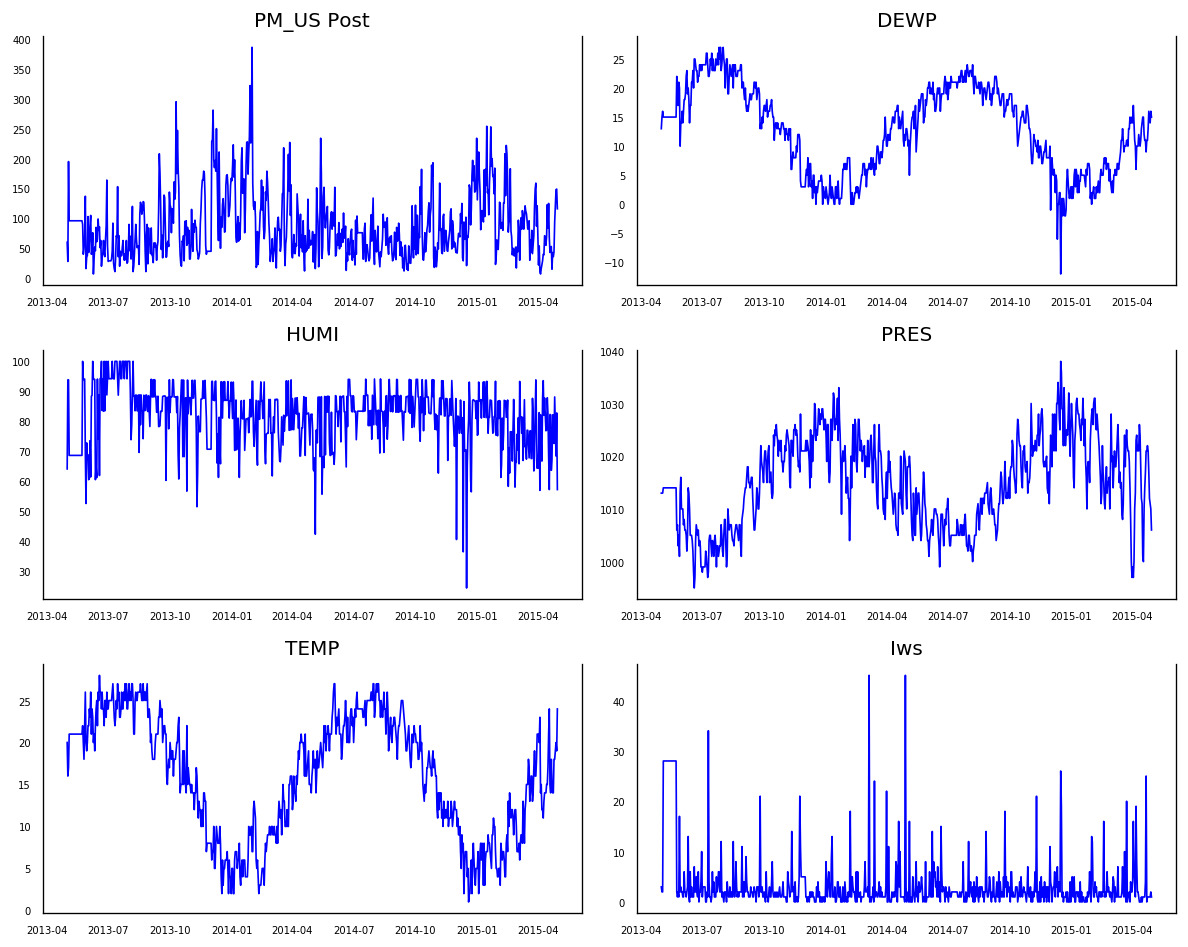

In [10]:
#preliminary plots of each variable
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data = dataset[dataset.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

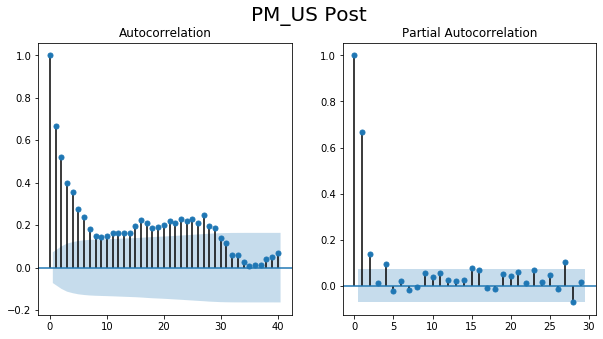

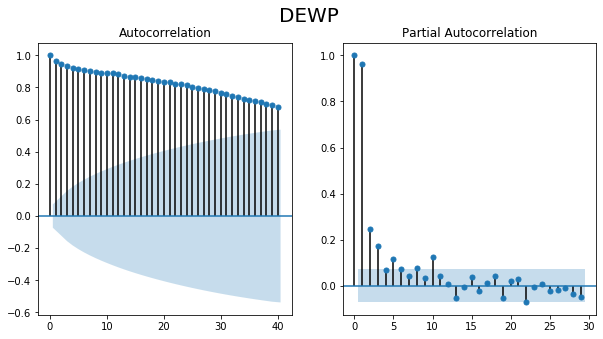

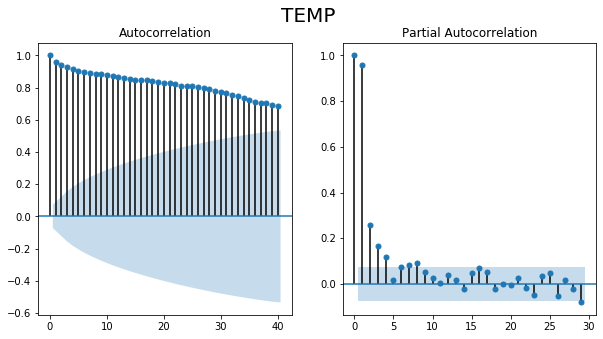

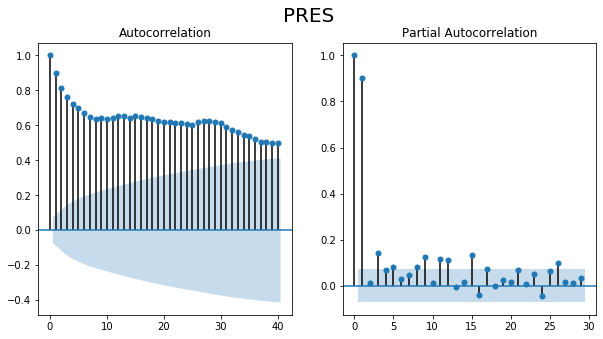

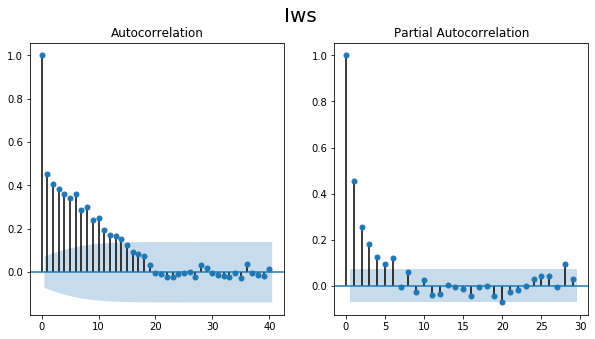

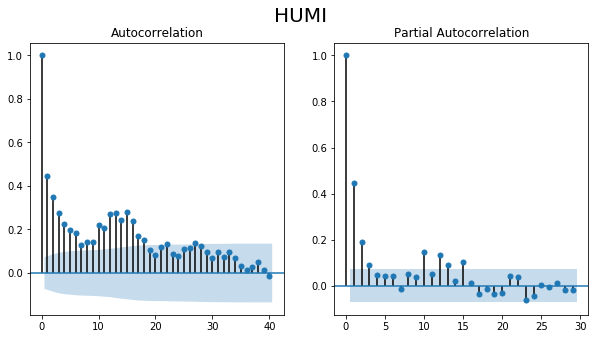

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PM_US Post', fontsize=20)
ax[0] = plot_acf(dataset['PM_US Post'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PM_US Post'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('DEWP', fontsize=20)
ax[0] = plot_acf(dataset['DEWP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['DEWP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('TEMP', fontsize=20)
ax[0] = plot_acf(dataset['TEMP'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['TEMP'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('PRES', fontsize=20)
ax[0] = plot_acf(dataset['PRES'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['PRES'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('Iws', fontsize=20)
ax[0] = plot_acf(dataset['Iws'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['Iws'], ax = ax[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
fig.suptitle('HUMI', fontsize=20)
ax[0] = plot_acf(dataset['HUMI'], ax = ax[0], lags = 40)
ax[1] = plot_pacf(dataset['HUMI'], ax = ax[1])

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(dataset, variables = dataset.columns) 

,PM_US Post_x,DEWP_x,HUMI_x,PRES_x,TEMP_x,Iws_x
PM_US Post_y,1.0000,0.0000,0.1421,0.0000,0.0000,0.0246
DEWP_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.2055
HUMI_y,0.1326,0.0002,1.0000,0.0003,0.0001,0.1108
PRES_y,0.0000,0.0000,0.4325,1.0000,0.0000,0.0967
TEMP_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0151
Iws_y,0.2237,0.1121,0.0013,0.0276,0.0379,1.0000


In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dataset)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
PM_US Post ::  260.36    > 83.9383   =>   True
DEWP   ::  161.32    > 60.0627   =>   True
HUMI   ::  91.47     > 40.1749   =>   True
PRES   ::  36.0      > 24.2761   =>   True
TEMP   ::  3.0       > 12.3212   =>   False
Iws    ::  0.01      > 4.1296    =>   False


In [14]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    #print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    #print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
        #print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        #print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        #print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
          
# ADF Test on each column
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PRES" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




In [15]:
train_diff = train.diff().dropna()
train_diff

,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws
Time,,,,,,
2013-05-02 03:00:00,-32.0,2.0,29.71,0.0,-4.0,-1.0
2013-05-03 03:00:00,167.0,1.0,0.04,0.0,1.0,0.0
2013-05-04 03:00:00,-99.0,-1.0,-25.23,1.0,4.0,26.0
2013-05-05 03:00:00,0.0,0.0,0.00,0.0,0.0,0.0
2013-05-06 03:00:00,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...
2014-12-01 03:00:00,0.0,-11.0,-47.03,7.0,0.0,-7.0
2014-12-02 03:00:00,-1.0,7.0,35.64,-1.0,-2.0,-1.0
2014-12-03 03:00:00,20.0,2.0,5.57,-5.0,1.0,-3.0


In [16]:
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM_US Post" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEWP" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HUMI" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PRES" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Iws" 
    -----------------------------------------------
 => Series is Stationary.




In [46]:
from statsmodels.tsa.api import VAR
model = VAR(train_diff)
    
x = model.select_order(maxlags=30)
x.summary()
#min AIC/FPE: lag 7

,AIC,BIC,FPE,HQIC
0,15.94,15.99,8.364e+06,15.96
1,14.99,15.32,3.239e+06,15.12
2,14.65,15.25*,2.294e+06,14.88
3,14.53,15.42,2.037e+06,14.87*
4,14.44,15.61,1.875e+06,14.90
5,14.37,15.82,1.740e+06,14.94
6,14.37,16.10,1.740e+06,15.04
7,14.36,16.38,1.733e+06,15.15
8,14.34*,16.63,1.693e+06*,15.24
9,14.37,16.94,1.747e+06,15.38


In [47]:
results = model.fit(maxlags=30, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Apr, 2020
Time:                     17:24:24
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    16.7288
Nobs:                     575.000    HQIC:                   15.3707
Log likelihood:          -8770.77    FPE:                1.99244e+06
AIC:                      14.5024    Det(Omega_mle):     1.21979e+06
--------------------------------------------------------------------
Results for equation PM_US Post
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.486582         1.642959           -0.296           0.767
L1.PM_US Post        -0.373057         0.047038           -7.931           0.000
L1.DEWP               5.608895         9.791231        

In [48]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic: [0,4]; 
#close to 2 = no significant serial correlation
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(train_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

PM_US Post : 2.01
DEWP   : 2.01
HUMI   : 2.04
PRES   : 2.01
TEMP   : 2.0
Iws    : 2.0


In [57]:
# Get the lag order
lag_order = results.k_ar
#print(lag_order)

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]

#results.forecast(dataset.values[-lag_order:], 30)
fc = results.forecast(y=forecast_input, steps=10)
result_forecast = pd.DataFrame(fc, index=dataset.index[-10:], columns=dataset.columns + '_1d')
#print(result_forecast)

In [58]:
def invert_transformation(train, result_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = result_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = train[col].iloc[-1] + df_fc[str(col)+ '_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train, result_forecast)       
#print(df_results.loc[:, ['PM_US Post_forecast','Iws_forecast', 'HUMI_forecast']])

#df_future_result = invert_transformation(train, fc_future)
#print(df_future_result)
     
#print(df_results.loc[:, ['PM_US Post_forecast', 'DEWP_forecast', 'TEMP_forecast', 'PRES_forecast', 'Iws_forecast', 'HUMI_forecast']]) #'

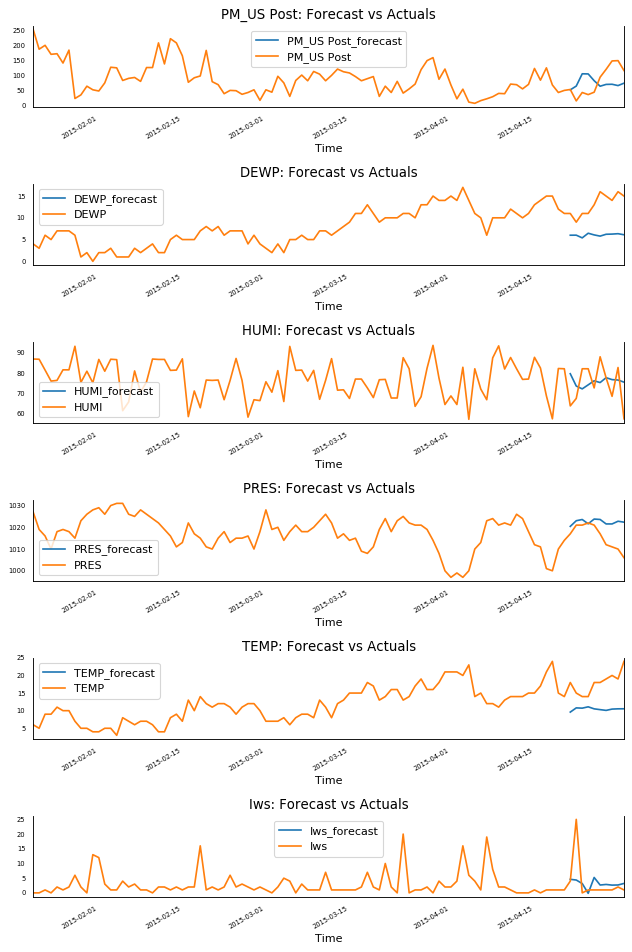

In [59]:
#results.plot_forecast(150, plot_stderr= False);
fig, axes = plt.subplots(nrows=int(len(dataset.columns)), ncols=1, dpi=80, figsize=(8,12))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dataset[col][-100:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [60]:
test = dataset[len(dataset)-146:]

In [55]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test[['PM_US Post', 'DEWP','HUMI','PRES', 'TEMP', 'Iws']][-10:], 
                                  df_results[['PM_US Post_forecast','DEWP_forecast','HUMI_forecast','PRES_forecast', 'TEMP_forecast', 'Iws_forecast']][-10:]))
print("Overall RMSE: ", rmse)

Overall RMSE:  22.431671029934286


In [61]:
rmse_PM = np.sqrt(mean_squared_error(test[['PM_US Post']][-10:], 
                                  df_results[['PM_US Post_forecast']][-10:]))
print("RMSE for Chengdu_PM2.5_forecast: ", rmse_PM)

rmse_DEWP = np.sqrt(mean_squared_error(test[['DEWP']][-10:], 
                                  df_results[['DEWP_forecast']][-10:]))
print("RMSE for DEWP_forecast: ", rmse_DEWP)

rmse_HUMI = np.sqrt(mean_squared_error(test[['HUMI']][-10:], 
                                  df_results[['HUMI_forecast']][-10:]))
print("RMSE for HUMI_forecast: ", rmse_HUMI)

rmse_PRES = np.sqrt(mean_squared_error(test[['PRES']][-10:], 
                                  df_results[['PRES_forecast']][-10:]))
print("RMSE for PRES_forecast: ", rmse_PRES)

rmse_TEMP = np.sqrt(mean_squared_error(test[['TEMP']][-10:], 
                                  df_results[['TEMP_forecast']][-10:]))
print("RMSE for TEMP_forecast: ", rmse_TEMP)

rmse_Iws = np.sqrt(mean_squared_error(test[['Iws']][-10:], 
                                  df_results[['Iws_forecast']][-10:]))
print("RMSE for Iws_forecast ", rmse_Iws)

RMSE for Chengdu_PM2.5_forecast:  55.30889298869844
RMSE for DEWP_forecast:  7.398982847973523
RMSE for HUMI_forecast:  10.389500593931118
RMSE for PRES_forecast:  8.40748377016857
RMSE for TEMP_forecast:  8.043177335198703
RMSE for Iws_forecast  6.853180139744624


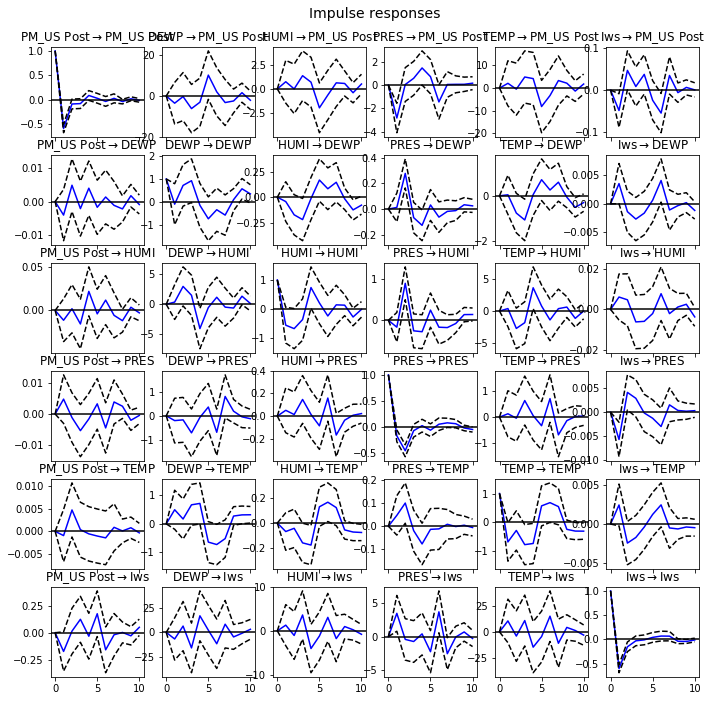

In [26]:
#impulse response analysis
irf = results.irf(10)
irf.plot(orth=False);

In [ ]:
#impulse response analysis wiht cumulative effect
irf.plot_cum_effects(orth=False);

In [ ]:
resid = results.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [ ]:
#Forecast Error Variance Decomposition (FEVD) method
fevd = results.fevd(5)
fevd.summary()

In [ ]:
results.fevd(20).plot();